# First data exploration

In this notebook we want to explore the dataset and to find some interesting visualization that looks at correlation between the channels. We will focus on one single day/hour and we will leave to another notebook understanding how the pattern we find here are common to the dataset or rather specific to the day we are here analyzing.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import signal
from skimage import io, feature
from scipy import ndimage
from itertools import product

from sdo.io import sdo_read

%matplotlib inline

In [3]:
# some configuration parameters used along the notebook
figsize=(10,10)
# we don't consider the  '1600', '1700' channels for this study
channels = ['0094', '0131', '0171', '0193', '0211', '0304', '0335']
colors = ['orange', 'green', 'blue', 'red', 'yellow', 'cyan', 'magenta']

Let's first pick up a date and time, for example , 2015-9-2, 12, 12, and start with simple images

## Row images

In [4]:
a = sdo_read(2015, 9, 2, 12, 12, channel=channels[0], subsample=4)
b = sdo_read(2015, 9, 2, 12, 12, instr='HMI', channel='by', subsample=4)

A first comparison beetween a EUV channel (left) and the magnetic field (right)

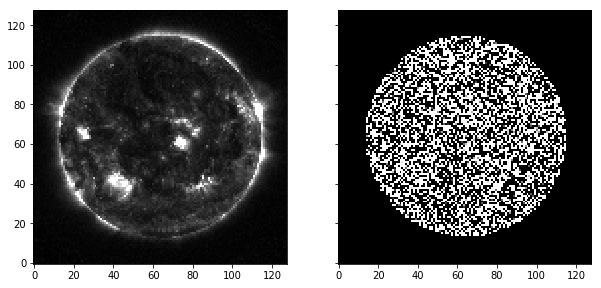

In [4]:
fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True)
ax[0].imshow(a, cmap='gray',clim=(0,20),origin='lower')
ax[1].imshow(b, cmap='gray',clim=(0,10), origin='lower')

Below the same day/hour in the 7 different channels, for two different intensity scale. The intensity is very different between the different channels. A normalization by channel is probably necessary to make the features more visible.

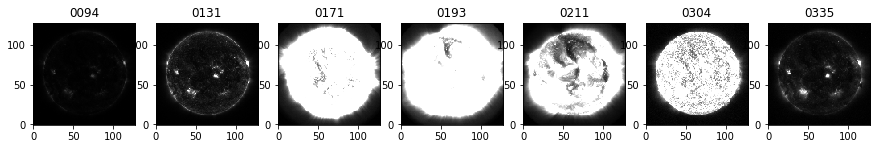

In [6]:
fig, ax = plt.subplots(1, 7, figsize=(15,10))
for i, channel in enumerate(channels):
    img = sdo_read(2015, 9, 2, 12, 12, channel=channel, subsample=4)
    ax[i].set_title(channel)
    ax[i].imshow(img, cmap='gray', clim=(0,200), origin='lower');

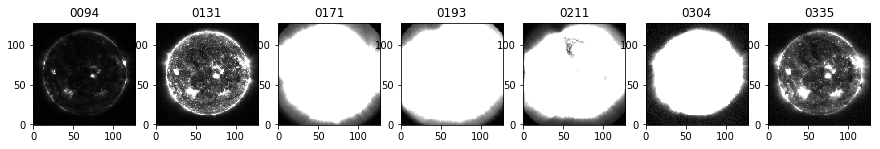

In [7]:
fig, ax = plt.subplots(1, 7, figsize=(15,10))
for i, channel in enumerate(channels):
    img = sdo_read(2015, 9, 2, 12, 12, channel=channel, subsample=4)
    ax[i].set_title(channel)
    ax[i].imshow(img, cmap='gray',clim=(0,50), origin='lower');

## 1-D Histograms

Let's look at the distribution of the pixel intensity in the different channels. As expected, most of the pixel have intensity 0 and the maximum value on the X axis varies a lot depending on the channel (from 100 to 10000, this is a factor 100). We can also note that in each channel there are outliers that are a factor 2 greater than the max of the not-outlier distribution.

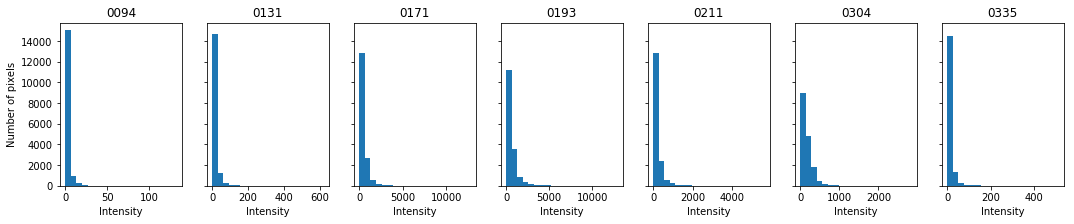

In [59]:
fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=True)
for i, channel in enumerate(channels):
    img = sdo_read(2015, 9, 2, 12, 12, channel=channel, subsample=4)
    ax[i].set_title(channel)
    ax[i].hist(x=pd.Series(np.ravel(img)), bins=20)
    ax[i].set_xlabel('Intensity')
ax[0].set_ylabel('Number of pixels');

We can order the channels according to the increasing maximum intensity:
    - 0094
    - 0335
    - 0131
    - 0304
    - 0211
    - 0171
    - 0193

Below the overplot of the channels, unfortunately, due to the large difference in the x-scale the overplot is not very clear. The distribution of the channels look similar, a part from a multiplication factor. Only channel 0304 looks different, it might be something specific to that day or a specific peculiarity of the channel. 0131 and 0335 tends to have more 0 intensity pixels.

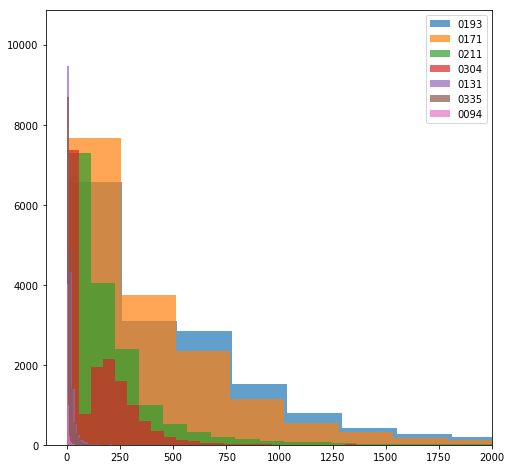

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ordered_channels = ['0094', '0335', '0131', '0304', '0211', '0171', '0193']
for i, channel in enumerate(ordered_channels[::-1]):
    img = sdo_read(2015, 9, 2, 12, 12, channel=channel, subsample=4)
    #sns.kdeplot(pd.Series(np.ravel(img)), label=channel, shade=True, cut=0)
    plt.hist(x=pd.Series(np.ravel(img)), bins=50, label=channel, alpha=0.7)
    plt.xlim(-100,2000)
    plt.legend()

## Pixel by pixel correlation

We first attempted to use the scipy correlate2d function but it is not clear how it computes the correlation and it does not seem what we want 

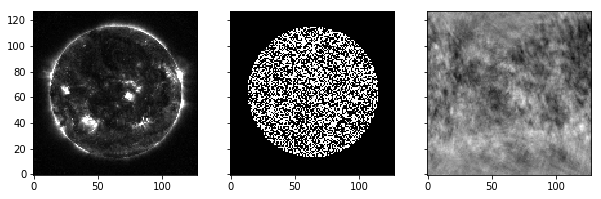

In [10]:
corr = signal.correlate2d(a, b, boundary='wrap', mode='same', fillvalue=255)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
ax[0].imshow(a, cmap='gray',clim=(0,20),origin='lower')
ax[1].imshow(b, cmap='gray',clim=(0,10), origin='lower')
ax[2].imshow(corr, cmap='gray', origin='lower')

Let's manually define a correlation pixel by pixel

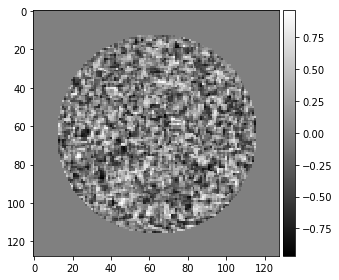

In [7]:
def correlation_coefficient(patch1, patch2):
    product = np.mean((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    stds = patch1.std() * patch2.std()
    if stds == 0:
        return 0
    else:
        product /= stds
        return product

def compute_correlation(a, b, d=1):
    "compute the correlation coefficient between patches centered on this pixel in the two images of interest"
    correlation = np.zeros_like(a)
    sh_row, sh_col = a.shape
    for i in range(d, sh_row - (d + 1)):
        for j in range(d, sh_col - (d + 1)):
            correlation[i, j] = correlation_coefficient(a[i - d: i + d + 1,
                                                        j - d: j + d + 1],
                                                        b[i - d: i + d + 1,
                                                        j - d: j + d + 1])
    return correlation

io.imshow(compute_correlation(a, b), cmap='gray', clim=(0,20))

## Correlation beetween channel pairs

Let's apply the function above to the channel pairs

In [5]:
channel_pairs = [pair for pair in product(channels,repeat=2) if pair[0]!=pair[1]]

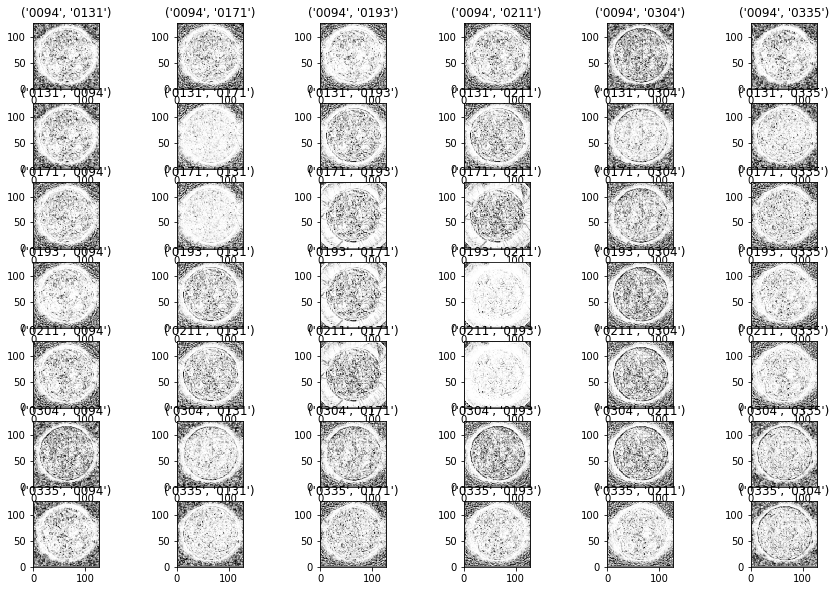

In [8]:
fig, ax = plt.subplots(7, 6, figsize=(15,10))
i = 0
j = 0
for channel_pair in channel_pairs:
    img1 = sdo_read(2015, 9, 2, 12, 12, channel=channel_pair[0], subsample=4)
    img2 = sdo_read(2015, 9, 2, 12, 12, channel=channel_pair[1], subsample=4)
    ax[i][j].set_title(channel_pair)
    ax[i][j].imshow(compute_correlation(img1, img2), cmap='gray', origin='lower')
    j = j + 1
    if j%6 == 0:
        i += 1
        j = 0

## Correlation pixel by pixel beetween HMI and each channel

When looking at the correlation beetween the Bz and the channel we see common structures appear in the correlation

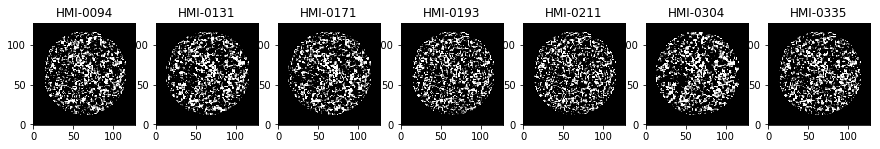

In [20]:
fig, ax = plt.subplots(1, 7, figsize=(15,15))
img2 = sdo_read(2015, 9, 2, 12, 12, instr='HMI', channel='bz', subsample=4)
for i, channel in enumerate(channels):
    img1 = sdo_read(2015, 9, 2, 12, 12, channel=channel, subsample=4)
    ax[i].set_title('HMI-' + channel)
    ax[i].imshow(compute_correlation(img1, img2), clim=(0,0.5), cmap='gray', origin='lower')

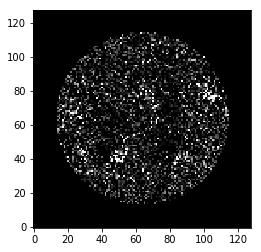

In [21]:
plt.imshow(img2, cmap='gray',clim=(0,20),origin='lower')

## 2d histograms beetween HMI-one channel and beetween pairs of channels

In [5]:
df = pd.DataFrame()
for i, channel in enumerate(channels):
    img = sdo_read(2015, 9, 2, 12, 12, channel=channel, subsample=4)
    df[channel] = pd.Series(np.ravel(img))
img = sdo_read(2015, 9, 2, 12, 12, instr='HMI', channel='bz', subsample=4)
df['HMI'] = pd.Series(np.ravel(img))

Below the statistics for each channel, HMI is Bz

In [6]:
df.describe()

,0094,0131,0171,0193,0211,0304,0335,HMI
count,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000
mean,2.908706,14.605936,425.990326,576.090393,211.884552,143.802643,13.702522,0.083164
std,4.419030,21.539181,578.595459,757.895264,306.406921,169.712646,20.909716,18.183210
min,0.000000,0.000000,0.000000,0.110800,0.087059,0.000000,0.000000,-827.269653
25%,0.604629,1.785859,41.258811,86.082647,36.930281,6.810160,2.912119,0.000000
50%,1.889729,10.014354,291.538330,394.690323,139.638657,116.367031,9.457701,0.000000
75%,3.528479,18.897325,585.435974,749.966446,260.029892,229.490623,16.569923,0.000000
max,133.176361,620.432678,12794.079102,12945.531250,5666.833496,2844.807861,511.680450,727.715210


We decided to normalize each channel for the following plots

In [7]:
normalized_df=(df-df.min())/(df.max()-df.min())

In [20]:
normalized_df.describe()

,0094,0131,0171,0193,0211,0304,0335,HMI
count,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000
mean,0.021841,0.023542,0.033296,0.044493,0.037375,0.050549,0.026779,0.532114
std,0.033182,0.034716,0.045224,0.058546,0.054071,0.059657,0.040865,0.011693
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.004540,0.002878,0.003225,0.006641,0.006502,0.002394,0.005691,0.532011
50%,0.014190,0.016141,0.022787,0.030480,0.024626,0.040905,0.018484,0.532011
75%,0.026495,0.030458,0.045758,0.057924,0.045872,0.080670,0.032383,0.532011
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


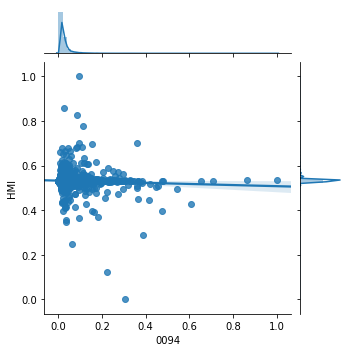

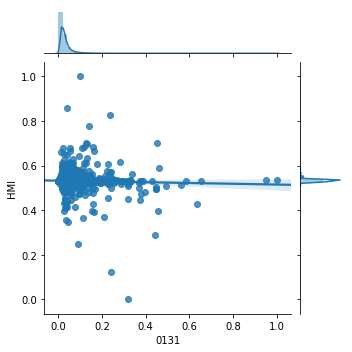

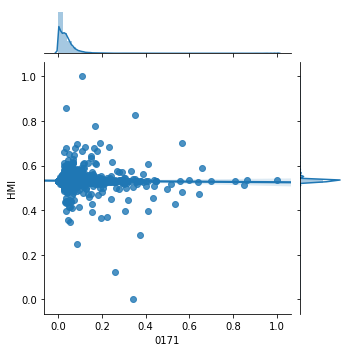

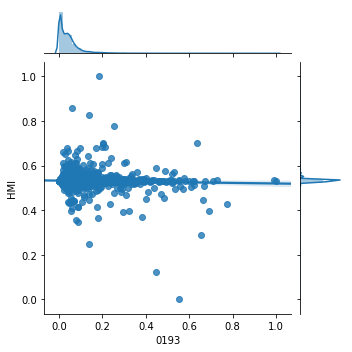

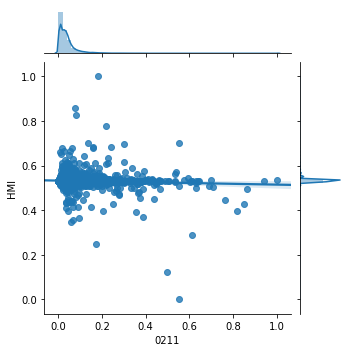

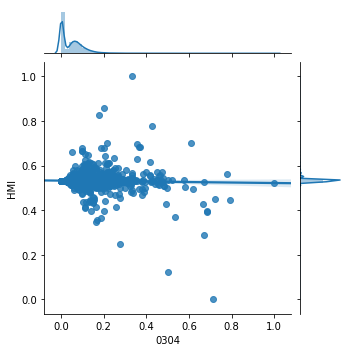

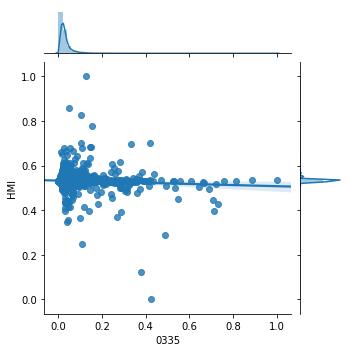

In [14]:
for i, channel in enumerate(channels):
    sns.jointplot(x=channel, y='HMI', data=normalized_df, kind="reg", height=5)

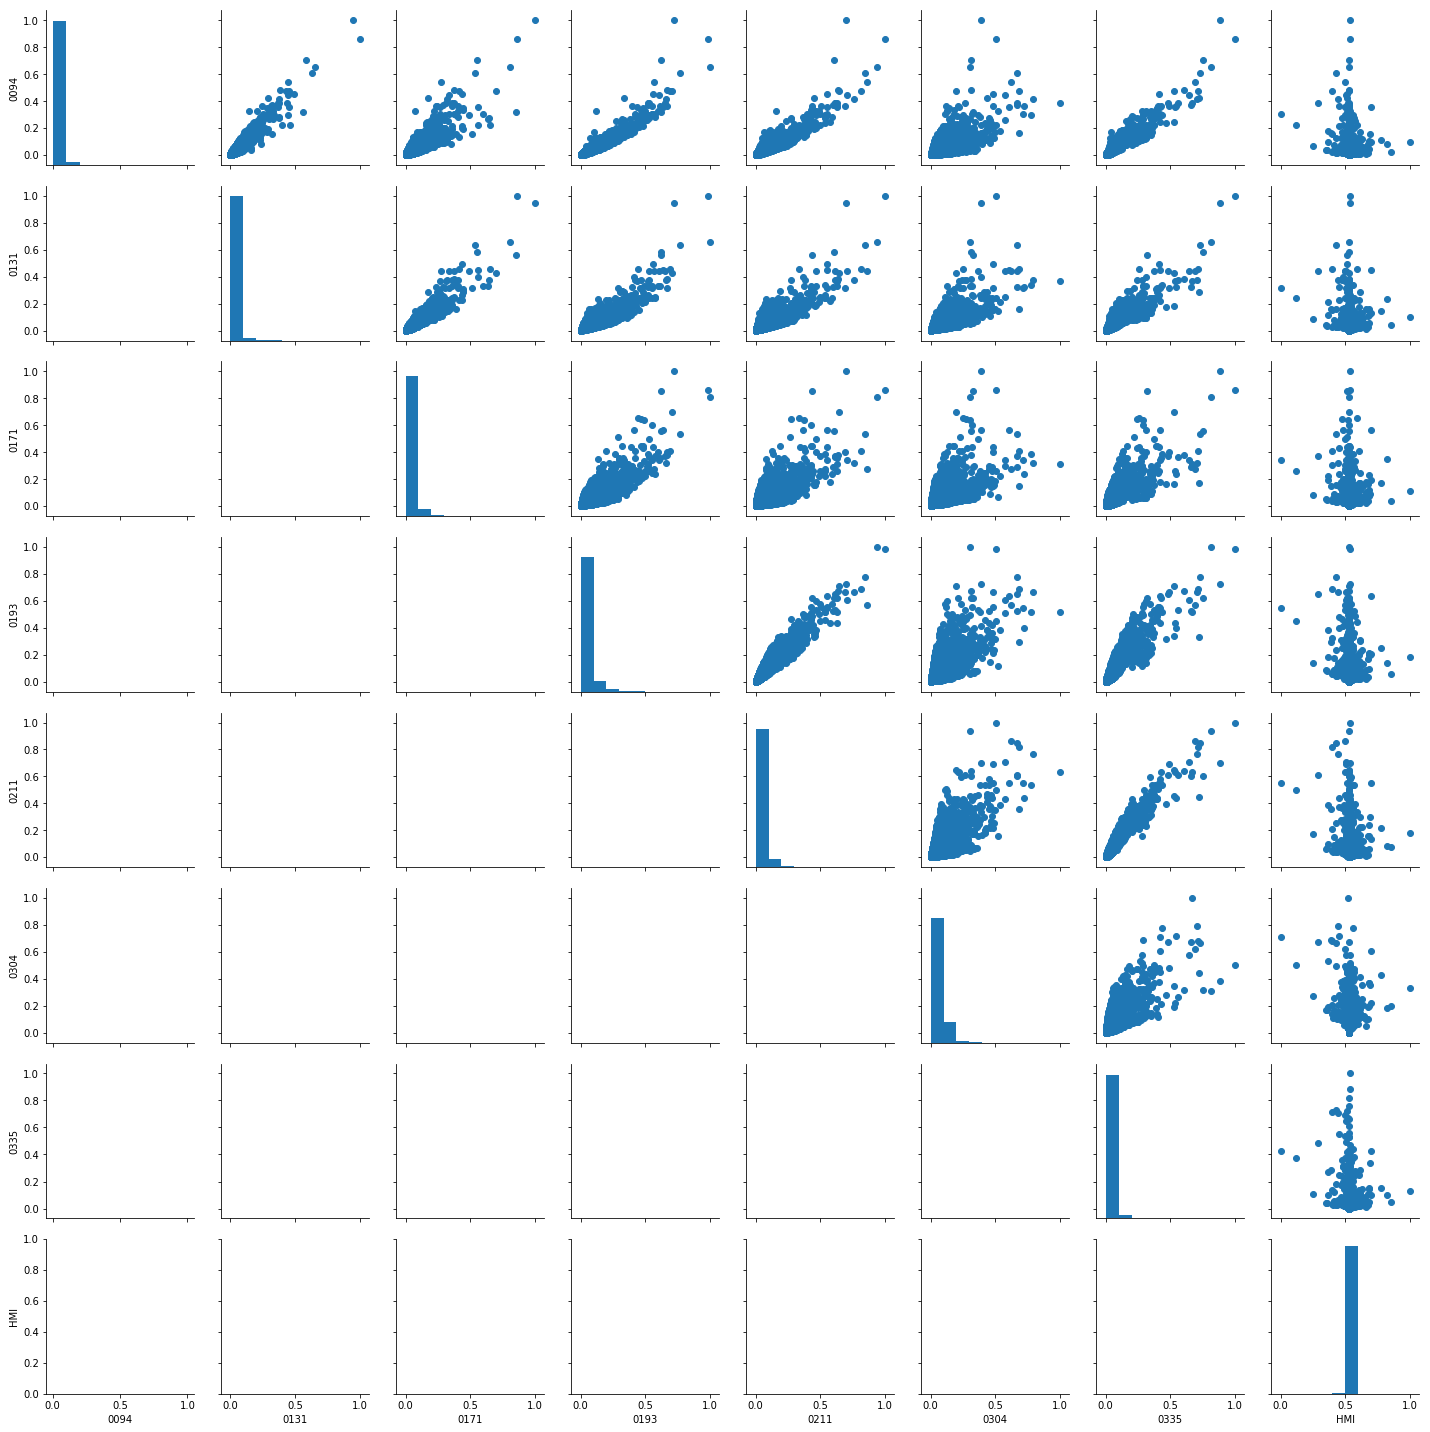

In [19]:
g = sns.PairGrid(normalized_df)
g.map_upper(plt.scatter)
g.map_diag(plt.hist, lw=3);

## Other

Other things that we can compute if we look at multiple days:
- evolution in time of a single metric (i.e. sum of pixel intensity, sum of intensity difference beetween EUV and HMI) for each channel 